<a href="https://colab.research.google.com/github/ak1909552/satellite-imagery/blob/main/download%26detect.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install earthengine-api
!pip install gdal
!pip install retry
!pip install numpy
!pip install pandas
!pip install unidecode
!pip install json
!pip install geojson
!pip install aiofiles

## Find the area of interest

In [2]:
import json
import requests
from geojson import Feature, FeatureCollection

In [3]:
def nominatim(aoi):
    r = requests.get(f'https://nominatim.openstreetmap.org/search?q={aoi}&polygon_geojson=1&format=geojson')
    j = r.json()

    polylist = []

    for feature in j['features']:
        
        type = feature['properties']['type']
        if type == 'administrative':
            geo = feature['geometry']
            props = feature['properties']
            bbox = feature['bbox']
            props['bbox'] = bbox
            features = []
            features.append(Feature(geometry = geo, properties = props))
            polylist.append(FeatureCollection(features))

    return polylist

In [4]:
def write(polylist, index):
    try:
        f = open('aoi.geojson', 'w')
        json.dump(polylist[index], f, indent = 4, ensure_ascii = False)
        f.close()
    except Exception as e:
        print(e)

In [5]:
def display(polylist):
    for count, poly in enumerate(polylist):
        print(f"{count}: {poly['features'][0]['properties']['display_name']}")

In [93]:
aoi = input("Enter the region of interest: ")
polylist = nominatim(aoi)
display(polylist)
index = int(input("Enter the index: "))
write(polylist, index)

Enter the region of interest: bahamas
0: The Bahamas
Enter the index: 0


## Search EarthEngine

In [7]:
import ee
ee.Authenticate()

ee.Initialize(opt_url='https://earthengine-highvolume.googleapis.com')

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=IG4Kb7A5TF03sAx6Y-dKT29xK9vs_56aLK12eS3vHCw&tc=xxF8Dz9D3Oh4sxFtBIAthqhaj7LK3rylAIcdBawfy6M&cc=tvDgfg-9XQwlNWW0Fivaimx8eCGHcUt0t4WMKjZy62Y

The authorization workflow will generate a code, which you should paste in the box below.
Enter verification code: 4/1AWgavdcH6m8pkb_RgFL5Zsq5z34iTdFoC8zbHJ87bGhf1K-yAsChKOO4U-s

Successfully saved authorization token.


In [94]:
b_file = open('./aoi.geojson', "r")
b_json = json.load(b_file)

multipoly = False
if b_json['features'][0]['geometry']['type'] == 'MultiPolygon': 
    multipoly = True

coordinates = b_json['features'][0]['geometry']['coordinates']

if multipoly:
    # roi = ee.Geometry.MultiPolygon(coordinates).convexHull(ee.ErrorMargin(1))
    roi = ee.Geometry.MultiPolygon(coordinates)
else:
    roi = ee.Geometry.Polygon(coordinates)
b_file.close()

In [95]:
start = '2019-09-08'
end = '2019-09-15'

In [10]:
def getS1Collection():
    """
    A function that returns an ee.ImageCollection() of Sentinel-1 images
    
    Output:
    Returns ee.ImageCollection() from Sentinel-1 
    """
    sent_1 = ee.ImageCollection('COPERNICUS/S1_GRD').filterDate(start, end) \
            .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV')) \
            .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH')) \
            .select('VV', 'VH') \
            .filter(ee.Filter.eq('instrumentMode', 'IW')) \
            .filterMetadata('resolution_meters', 'equals', 10) \
            .filterBounds(roi)
    
    return sent_1

In [11]:
def getS2Collection(clouds):
    '''
    A function that returns an ee.ImageCollection() of Sentinel-2 images

    Output:
    Returns ee.ImageCollection() from Sentinel-2
    '''

    sent_2 = ee.ImageCollection('COPERNICUS/S2_SR').filterDate(start, end) \
    .filter(ee.Filter.lte('CLOUDY_PIXEL_PERCENTAGE', clouds)) \
    .filterBounds(roi)

    return sent_2

In [12]:
def getImageID(collection):
    ids = collection.aggregate_array('system:index').getInfo()
    return list(map(lambda id: 'COPERNICUS/S2/' + id, ids))

In [96]:
clouds = 20
images = getImageID(getS2Collection(clouds))
# for image in images:
#     print(image)
print(len(images)) 

46


## Download the images

In [14]:
import shutil
from threading import Lock
import os
import concurrent.futures
from retry import retry
import multiprocessing
import functools
import asyncio
import aiohttp
import aiofiles
from osgeo import gdal

In [ ]:
# ee.Initialize(opt_url='https://earthengine-highvolume.googleapis.com')

In [15]:
class MyImage():
    def __init__(self, id):
        self.id = id
        self.img = ee.Image(id)
        self.download_lock = Lock()



    def getAreaOfInterest(self):
        lring = ee.Geometry(self.img.get('system:footprint')).coordinates()
        aoi = ee.Geometry.Polygon(lring)
        grid = aoi.coveringGrid(aoi.projection(), 20000)
        return grid.aggregate_array('.geo').getInfo()

    @retry(tries=2, delay=1, backoff=2)
    def getURLs(self):
        urls = []
        for tile in self.getAreaOfInterest():
            tessel = ee.Geometry(tile)
            chip = self.img.clip(tessel)
            with self.download_lock:
                url = chip.getDownloadURL({
                    'bands': ['B4', 'B3', 'B2'],
                    'scale': 10,
                    'format': 'GEO_TIFF',
                    'dimensions': '256x256'
                })
            urls.append(url)
        return urls


    def downloadTile(self, url, pathToTiles, index):       
        r = requests.get(url, stream=True)
        
        if r.status_code != 200:
            raise r.raise_for_status()
        file = self.id.replace('/','_')
        filename = f'S2_{file}_tile_{index:05d}.tif'
        truename = os.path.join(pathToTiles, filename)
        with open(truename, 'wb') as out_file:
            shutil.copyfileobj(r.raw, out_file)

    # @retry(tries=2, delay=1, backoff=2)
    async def downloadTile_asyncio(self, url, pathToTiles, index):
        tries = 3
        file = self.id.replace('/','_')
        filename = f'S2_{file}_tile_{index:05d}.tif'
        truename = os.path.join(pathToTiles, filename)
        async with aiohttp.ClientSession() as session:
            # async with session.get(url) as r:
            #     if r.status != 200:
            #         raise Exception(f'Download failed with response status: {r.status}')
            #     file_content = await r.read()
            #     async with aiofiles.open(truename, 'wb') as f:
            #         await f.write(file_content)
            #         print(f'{filename} saved')
            r = await session.get(url)
            while tries and r.status != 200:
                r = await session.get(url)
            if r.status != 200:
                raise Exception(f'Download failed with response status: {r.status}')
            file_content = await r.read()
            async with aiofiles.open(truename, 'wb') as f:
                await f.write(file_content)
                print(f'{filename} saved')


    def downloadChips(self, pathToTiles):
        urls = self.getURLs()
        print(f'{len(urls)} tiles generated.')
        # with concurrent.futures.ProcessPoolExecutor(max_workers = 8) as pool:
        #     for index, url in enumerate(urls):
        #         pool.submit(self.downloadTile, url, index, pathToTiles) 
        
        for i,url in enumerate(urls):            
            self.downloadTile(url, pathToTiles, i)
            # print(f'image {i} done.')

    async def downloadChips_asyncio(self, pathToTiles):
        urls = self.getURLs()
        await asyncio.gather(*[self.downloadTile_asyncio(url, pathToTiles, index) for index, url in enumerate(urls)])

    def stitchChips(self, pathToTiles, pathToImages):
        nodata = 0
        sat = 'S2'
        file = self.id.replace('/', '_')
        os.system(f'gdalbuildvrt -srcnodata {nodata} -vrtnodata nan -r cubicspline {pathToTiles}/{sat}_{file}_merged.vrt {pathToTiles}/{sat}_{file}*.tif 2> /dev/null')
        # os.system(f'gdalbuildvrt {pathToTiles}/{sat}_{file}_merged.vrt {pathToTiles}/{sat}_{file}*.tif')
        os.system(f'gdal_translate -a_nodata nan --config GDAL_NUM_THREADS ALL_CPUS {pathToTiles}/{sat}_{file}_merged.vrt {pathToImages}/{sat}_{file}_merge.tif ')
        os.system(f'rm {pathToTiles}/*')
    
    
    def stitchChips2(self, pathToTiles, pathToImages):
        file = self.id.replace('/', '_')
        gdal.BuildVRT(os.path.join())
    

In [ ]:
if __name__ == '__main__':

    cwd = os.getcwd()

    pathToTiles = os.path.join(cwd, 'tiles')
    pathToImages = os.path.join(cwd, 'images')

    if not os.path.exists(pathToTiles):
        os.makedirs(pathToTiles)
    if not os.path.exists(pathToImages):
        os.makedirs(pathToImages)

    for image in images:
        obj = MyImage(image)
        await obj.downloadChips_asyncio(pathToTiles)
        # asyncio.run(obj.downloadChips_asyncio(pathToTiles))
        # obj.downloadChips(pathToTiles)
        obj.stitchChips(pathToTiles, pathToImages)
        print('done')

dont immediately run this cell

In [ ]:
!rm tiles/*
!rm images/*

In [98]:
pathToTiles = os.path.join(cwd, 'tiles')
pathToImages = os.path.join(cwd, 'images')

directories = os.listdir(pathToImages)

def firstn(n):
    num = 0
    while num < n:
        yield num
        num += 1

gen = firstn(len(directories))

## Visualize the images
Keep running this cell to get new images

3


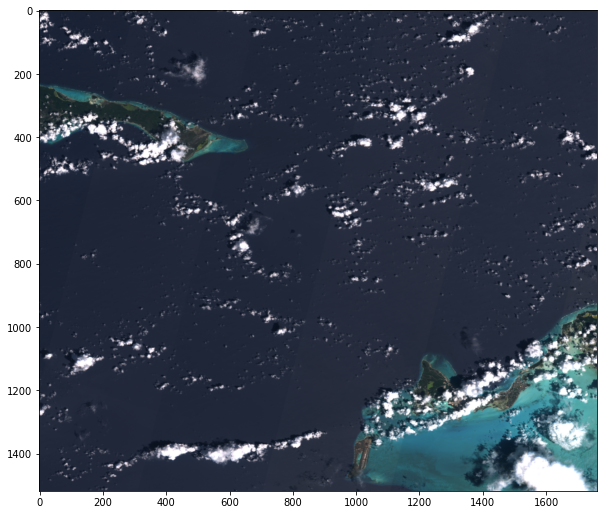

In [102]:
import matplotlib.pyplot as plt
import numpy as np



fp = '/content/images/'

dataset = gdal.Open(fp + directories[next(gen)])


print(dataset.RasterCount)

band1 = dataset.GetRasterBand(1) # Red channel
band2 = dataset.GetRasterBand(2) # Green channel
band3 = dataset.GetRasterBand(3) # Blue channel

b1 = band1.ReadAsArray()
b2 = band2.ReadAsArray()
b3 = band3.ReadAsArray()

scale = 12

b1 = (b1 / 65535) * scale
b2 = (b2 / 65535) * scale
b3 = (b3 / 65535) * scale
img = np.dstack((b1, b2, b3))
f = plt.figure(figsize=(10, 10))
# plt.imshow(b2)
plt.imshow(img)
# plt.savefig('Tiff.png')
plt.show()